In [1]:
import numpy as np
import pandas as pd
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, confusion_matrix, auc, roc_curve
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb

/Users/keiichirosato/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


In [2]:
df = pd.read_csv("モデル構築用.csv", encoding="sjis")
origin_columns = df.columns
df.columns = ["offer_date","NO","offer_time","baitai_dai","baitai_shousai","uketsuke_jikantai","uketsuke_keitai","shinki_jidokeiyaku","toriatsukai_tenban","kanri_tenban","sex","age","birth","jis","doku","sinshoku_dai","sinshoku_shousai","koyo","shugyo","kaisha_kibo","nenshu","zaisha","jukyo","kyoju","yachin","kazoku_kousei","hoken_shokushu","shunyu_shoumei","dokushin","doukyo","fuyo","fuyo_child","shotoku_shoumei","meigi","jigyo_keitai","jigyosho","month12_jiko"]
df.head()

,offer_date,NO,offer_time,baitai_dai,baitai_shousai,uketsuke_jikantai,uketsuke_keitai,shinki_jidokeiyaku,toriatsukai_tenban,kanri_tenban,...,shunyu_shoumei,dokushin,doukyo,fuyo,fuyo_child,shotoku_shoumei,meigi,jigyo_keitai,jigyosho,month12_jiko
0,2013/2/3,1.820570e+12,133504,3,2,3,502,0,182,182,...,0,1,2,0,0,0,0,6,0,0
1,2013/6/18,5.050290e+12,145329,5,99,0,1,2814,2814,505,...,0,0,1,2,1,0,0,0,0,0
2,2013/6/28,1.820590e+12,115136,5,99,0,1,2779,2779,182,...,1,0,1,1,0,8,1,0,0,0
3,2013/8/9,1.270660e+12,95034,5,99,0,1,223,223,127,...,0,1,2,0,0,0,0,0,0,0
4,2014/1/27,2.090350e+12,165240,5,99,0,1,1836,1836,209,...,0,0,2,0,0,0,0,0,0,0


In [3]:
df = df.drop(['offer_date', 'birth'], axis=1)
df.head()

,NO,offer_time,baitai_dai,baitai_shousai,uketsuke_jikantai,uketsuke_keitai,shinki_jidokeiyaku,toriatsukai_tenban,kanri_tenban,sex,...,shunyu_shoumei,dokushin,doukyo,fuyo,fuyo_child,shotoku_shoumei,meigi,jigyo_keitai,jigyosho,month12_jiko
0,1.820570e+12,133504,3,2,3,502,0,182,182,1,...,0,1,2,0,0,0,0,6,0,0
1,5.050290e+12,145329,5,99,0,1,2814,2814,505,1,...,0,0,1,2,1,0,0,0,0,0
2,1.820590e+12,115136,5,99,0,1,2779,2779,182,1,...,1,0,1,1,0,8,1,0,0,0
3,1.270660e+12,95034,5,99,0,1,223,223,127,1,...,0,1,2,0,0,0,0,0,0,0
4,2.090350e+12,165240,5,99,0,1,1836,1836,209,1,...,0,0,2,0,0,0,0,0,0,0


In [4]:
train_df, test_df = train_test_split(df, test_size = 0.1, random_state=0)
train_X = train_df.drop('month12_jiko',axis=1)
test_X = test_df.drop('month12_jiko',axis=1)
train_y = train_df['month12_jiko']
test_y = test_df['month12_jiko']
train_lgb = lgb.Dataset(train_X, train_y)
test_lgb = lgb.Dataset(test_X, test_y, reference=train_lgb)

In [15]:
#営業利益の算出(一次関数_ver2)
def operating_profit_linear_ver2(y_pred_reg, y_pred_cla, y_test, offset_n, offset_m):
    gain_list = []
    loss_list = []
    for i in y_pred_reg:
        if i > offset_n:
            gain_list.append(0)
        elif i <= offset_n and i >= offset_m:
            gain_list.append(int((-45/(offset_n-offset_m))*i+(45*offset_n/(offset_n-offset_m))+5))
        elif i < offset_m:
            gain_list.append(50)
    gain = np.sum(gain_list)
    for i in range(len(y_pred_cla)):
        if (y_pred_cla[i] == 0 and y_test[i] == 1):
            loss_list.append(gain_list[i])
        else:
            loss_list.append(0)
    loss = np.sum(loss_list)
    return gain, loss, int(gain*0.18-loss)

In [5]:
#テストデータの分類
print('事故', np.sum(test_df['month12_jiko'] == 1))
print('安全', np.sum(test_df['month12_jiko'] == 0))

事故 150
安全 913


In [283]:
model_reg = lgb.LGBMRegressor()
model_reg.fit(train_X, train_y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [284]:
pred_y_reg_array = model_reg.predict(test_X)
pred_y_reg = []
for i in pred_y_reg_array:
    if i >= 0:
        pred_y_reg.append(i)
    elif i < 0:
        pred_y_reg.append(0)
pred_y_reg = np.array(pred_y_reg)

In [285]:
pred_y_reg

array([0.11745439, 0.22237821, 0.12617095, ..., 0.07356041, 0.04720744,
       0.        ])

In [286]:
model_cla = lgb.LGBMClassifier(max_dapth=20,learning_rate=0.1)
model_cla.fit(train_X, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_dapth=20,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [287]:
pred_y_cla = model_cla.predict_proba(test_X)
pred_y_cla = np.argmax(pred_y_cla, axis=1)

In [288]:
#分類正解率
accuracy_score(test_y, pred_y_cla)

0.8532455315145814

In [289]:
#RF分類の結果
confusion_matrix(test_y, pred_y_cla, labels=[0,1])

array([[897,  16],
       [140,  10]])

# ==============================================================

In [290]:
#営業利益の算出(一次関数)
def operating_profit_linear(y_pred_reg, y_pred_cla, y_test, offset):
    gain_list = []
    loss_list = []
    for i in y_pred_reg:
        if i > offset:
            gain_list.append(0)
        elif i <= offset:
            gain_list.append(int(-(45*i)/offset+50))
    gain = np.sum(gain_list)
    for i in range(len(y_pred_cla)):
        if (y_pred_cla[i] == 0 and y_test[i] == 1):
            loss_list.append(gain_list[i])
        else:
            loss_list.append(0)
    loss = np.sum(loss_list)
    return gain, loss, int(gain*0.18-loss)

In [291]:
para_list = [i*0.01 for i in range(1,101)]
profit_list = []
for para in para_list:
    binary_pred_y_reg = []
    for j in pred_y_reg:
        if j > para:
            binary_pred_y_reg.append(1)
        elif j <= para:
            binary_pred_y_reg.append(0)
    profit_list.append(operating_profit_linear(pred_y_reg, binary_pred_y_reg, list(test_y), para)[2])
para_list.insert(0, 0)
profit_list.insert(0, 0)

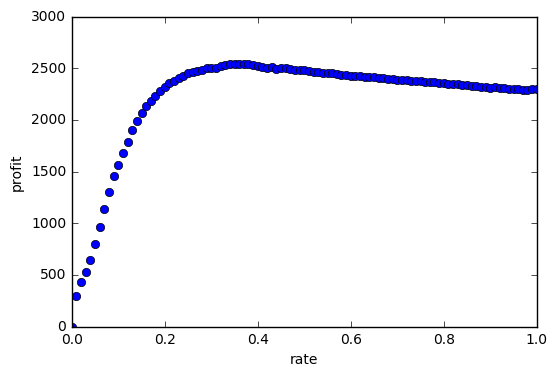

In [292]:
plt.figure()
plt.plot(para_list, profit_list, 'o')
plt.xlabel('rate')
plt.ylabel("profit")
plt.show()

In [293]:
print(np.max(profit_list))
print(np.argmax(profit_list))

2544
35


In [294]:
#最大利益の場合をバイナリ化
threshold = np.argmax(profit_list)/100
binary_pred_y_reg = []
for i in pred_y_reg:
    if i > threshold:
        binary_pred_y_reg.append(1)
    elif i <= threshold:
        binary_pred_y_reg.append(0)

In [275]:
#最大利益の場合でRF回帰の結果を0,1に変換した結果
confusion_matrix(test_y, binary_pred_y_reg, labels=[0,1])

array([[1747,   62],
       [ 269,   48]])

# ==============================================================

In [277]:
para_list = [i*0.01 for i in range(1,101)]
profit_list = []
for para_n in para_list:
    profit_list_m = []
    binary_pred_y_reg = []
    for j in pred_y_reg:
        if j > para_n:
            binary_pred_y_reg.append(1)
        elif j <= para_n:
            binary_pred_y_reg.append(0)
    for para_m in para_list:
        if para_m < para_n:
            profit_list_m.append(operating_profit_linear_ver2(pred_y_reg, binary_pred_y_reg, list(test_y), para_n, para_m)[2])
        else:
            profit_list_m.append(0)
            #profit_list_m.insert(0, 0)
    profit_list.append(profit_list_m)
#para_list.insert(0, 0)

In [278]:
np.max(profit_list)

5776

In [187]:
profit_list_max_n = []
for i in range(len(profit_list)):
    profit_list_max_n.append(np.max(profit_list[i]))

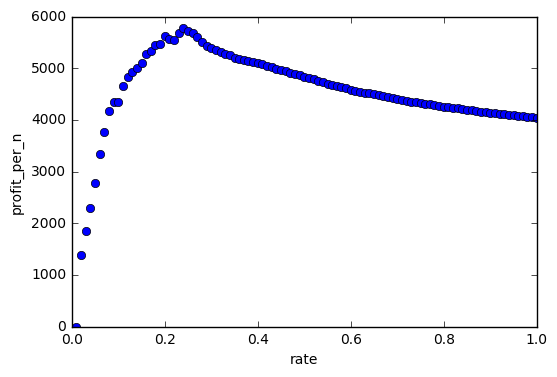

In [188]:
plt.figure()
plt.plot(para_list, profit_list_max_n, 'o')
plt.xlabel('rate')
plt.ylabel("profit_per_n")
plt.show()

# アンサンブル？

In [6]:
#RF回帰モデル作成
rf_reg = RandomForestRegressor(verbose = 1, n_estimators=100, max_depth=20)
rf_reg.fit(train_X,train_y)
rf_pred_y_reg = rf_reg.predict(test_X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [7]:
#lightBGM回帰モデル作成
model_reg = lgb.LGBMRegressor()
model_reg.fit(train_X, train_y)
bgm_pred_y_reg_array = model_reg.predict(test_X)
bgm_pred_y_reg = []
for i in bgm_pred_y_reg_array:
    if i >= 0:
        bgm_pred_y_reg.append(i)
    elif i < 0:
        bgm_pred_y_reg.append(0)
bgm_pred_y_reg = np.array(bgm_pred_y_reg)

In [8]:
#XGboost回帰モデル作成
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(train_X, train_y)
xgb_pred_y_reg_array = xgb_reg.predict(test_X)
xgb_pred_y_reg = []
for i in xgb_pred_y_reg_array:
    if i >= 0:
        xgb_pred_y_reg.append(i)
    elif i < 0:
        xgb_pred_y_reg.append(0)
xgb_pred_y_reg = np.array(xgb_pred_y_reg)

In [9]:
rf_pred_y_reg

array([0.12305556, 0.21261336, 0.09737404, ..., 0.16      , 0.14027523,
       0.02019227])

In [10]:
bgm_pred_y_reg

array([0.11745439, 0.22237821, 0.12617095, ..., 0.07356041, 0.04720744,
       0.        ])

In [11]:
xgb_pred_y_reg

array([0.13980782, 0.29546767, 0.15890288, ..., 0.12786466, 0.15324959,
       0.        ])

In [12]:
acu_rf = 1/mean_squared_error(test_y, rf_pred_y_reg)
acu_bgm =1/ mean_squared_error(test_y, bgm_pred_y_reg)
acu_xgb = 1/mean_squared_error(test_y, xgb_pred_y_reg)

In [13]:
sum_acu = acu_rf + acu_bgm + acu_xgb
pred_y_reg = (acu_rf*rf_pred_y_reg + acu_bgm*bgm_pred_y_reg + acu_xgb*xgb_pred_y_reg) / sum_acu

In [16]:
para_list = [i*0.01 for i in range(1,101)]
profit_list = []
for para_n in para_list:
    profit_list_m = []
    binary_pred_y_reg = []
    for j in pred_y_reg:
        if j > para_n:
            binary_pred_y_reg.append(1)
        elif j <= para_n:
            binary_pred_y_reg.append(0)
    for para_m in para_list:
        if para_m < para_n:
            profit_list_m.append(operating_profit_linear_ver2(pred_y_reg, binary_pred_y_reg, list(test_y), para_n, para_m)[2])
        elif para_m == para_n:
            profit_list_m.append(int(45*para_n))
        else:
            profit_list_m.append(0)
            #profit_list_m.insert(0, 0)
    profit_list.append(profit_list_m)
#para_list.insert(0, 0)

In [17]:
np.max(profit_list)

3300

In [18]:
profit_list_max_n = []
for i in range(len(profit_list)):
    profit_list_max_n.append(np.max(profit_list[i]))

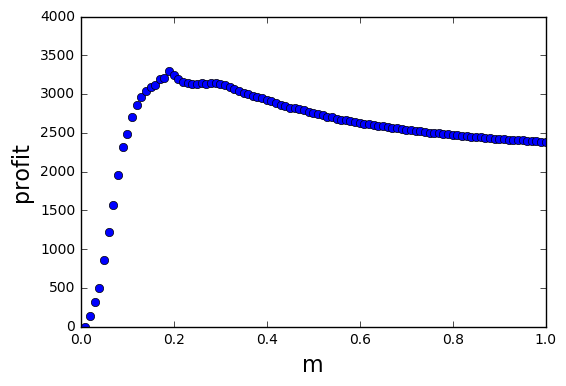

In [19]:
plt.figure()
plt.plot(para_list, profit_list_max_n, 'o')
plt.xlabel('m', fontsize=16)
plt.ylabel("profit", fontsize=16)
plt.ylim(0,4000)
plt.show()

In [20]:
#最大利益の場合をバイナリ化
threshold = (np.argmax(profit_list_max_n)+1)/100
binary_pred_y_reg = []
for i in pred_y_reg:
    if i > threshold:
        binary_pred_y_reg.append(1)
    elif i <= threshold:
        binary_pred_y_reg.append(0)

In [21]:
operating_profit_linear_ver2(pred_y_reg, binary_pred_y_reg, list(test_y), threshold, threshold-0.01)[2]

3300

In [22]:
#最大利益の場合でRF回帰の結果を0,1に変換した結果
confusion_matrix(test_y, binary_pred_y_reg, labels=[0,1])

array([[687, 226],
       [ 70,  80]])

In [23]:
precision, recall, thresholds = roc_curve(test_y, pred_y_reg)
auc(precision, recall)

0.7131069733479372

In [24]:
precision, recall, thresholds = roc_curve(test_y, binary_pred_y_reg)
auc(precision, recall)

0.6428988682000729

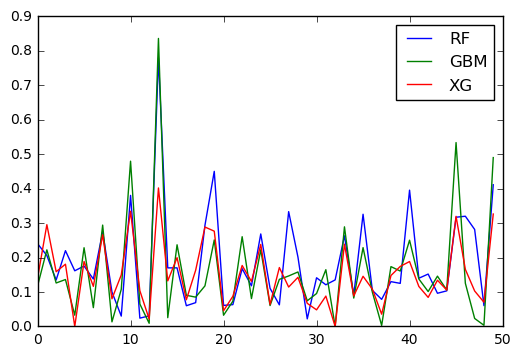

In [303]:
plt.figure()
plt.plot(rf_pred_y_reg[0:50], label="RF")
plt.plot(bgm_pred_y_reg[0:50], label="GBM")
plt.plot(xgb_pred_y_reg[0:50], label="XG")
plt.legend()
plt.show()

In [304]:
pred_y_reg=(rf_pred_y_reg+bgm_pred_y_reg+xgb_pred_y_reg)/3

In [305]:
para_list = [i*0.01 for i in range(1,101)]
profit_list = []
for para in para_list:
    binary_pred_y_reg = []
    for j in pred_y_reg:
        if j > para:
            binary_pred_y_reg.append(1)
        elif j <= para:
            binary_pred_y_reg.append(0)
    profit_list.append(operating_profit_linear(pred_y_reg, binary_pred_y_reg, list(test_y), para)[2])
para_list.insert(0, 0)
profit_list.insert(0, 0)

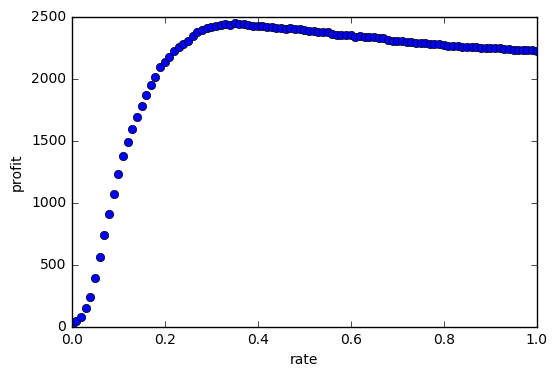

In [306]:
plt.figure()
plt.plot(para_list, profit_list, 'o')
plt.xlabel('rate')
plt.ylabel("profit")
plt.show()

In [307]:
print(np.max(profit_list))
print(np.argmax(profit_list))

2448
35


In [308]:
#最大利益の場合をバイナリ化
threshold = np.argmax(profit_list)/100
binary_pred_y_reg = []
for i in pred_y_reg:
    if i > threshold:
        binary_pred_y_reg.append(1)
    elif i <= threshold:
        binary_pred_y_reg.append(0)

In [309]:
#最大利益の場合でRF回帰の結果を0,1に変換した結果
confusion_matrix(test_y, binary_pred_y_reg, labels=[0,1])

array([[871,  42],
       [125,  25]])

In [310]:
para_list = [i*0.01 for i in range(1,101)]
profit_list = []
for para_n in para_list:
    profit_list_m = []
    binary_pred_y_reg = []
    for j in pred_y_reg:
        if j > para_n:
            binary_pred_y_reg.append(1)
        elif j <= para_n:
            binary_pred_y_reg.append(0)
    for para_m in para_list:
        if para_m < para_n:
            profit_list_m.append(operating_profit_linear_ver2(pred_y_reg, binary_pred_y_reg, list(test_y), para_n, para_m)[2])
        else:
            profit_list_m.append(0)
            #profit_list_m.insert(0, 0)
    profit_list.append(profit_list_m)
#para_list.insert(0, 0)

In [311]:
np.max(profit_list)

3260

In [314]:
precision, recall, thresholds = roc_curve(test_y, pred_y_reg)
auc(precision, recall)

0.7090909090909091